In [197]:
import math
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

In [49]:
import sys
sys.path.insert(0, 'Algorithm_of_peak_picking')

In [48]:
!git clone https://github.com/DahanDaniel/Algorithm_of_peak_picking.git

Klonowanie do „Algorithm_of_peak_picking”...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 87 (delta 52), reused 33 (delta 15), pack-reused 0
Rozpakowywanie obiektów: 100% (87/87), 24.55 KiB | 644.00 KiB/s, gotowe.


In [50]:
from Algorithm_of_peak_picking.RadonClass import *

In [108]:
SERIES  = 20
RESOLUTION = 2 ** 7 # number of points describing spectra
DWMIN, DWMAX, DDW = -10, 10, 20. / 256 # Domain of rates of change

In [20]:
@tf.function
def get(amplitude, frequency, damping, speed):
    t = tf.range(RESOLUTION, dtype = tf.float32) / RESOLUTION
    f = frequency + speed * tf.range(SERIES, dtype = tf.float32)
    FID = tf.complex(amplitude, 0.) * \
          tf.exp(2. * math.pi * (tf.complex(0., f)[:, None] - tf.complex(damping, 0.)) * tf.complex(t, 0.)) * \
          tf.cast(tf.logical_and(0 <= f, f <= RESOLUTION), tf.complex64)[:, None]
    FID = tf.concat([FID[:, : 1] / 2., FID[:, 1:]], 1)
    b = 2. * math.pi * tf.complex(0., tf.range(DWMIN, DWMAX, DDW, dtype = tf.float32))[:, None] * tf.complex(t, 0.)
    p = tf.exp(-b[:, None] * tf.complex(tf.range(SERIES, dtype = tf.float32), 0.)[:, None]) * FID
    return tf.math.real(tf.signal.fft(tf.reduce_sum(p, 1)))

In [21]:
def generate():
    while True:
        amplitude = tf.random.uniform((), 0.1, 5)
        frequency = tf.random.uniform((), 10, 2 ** 7 - 10)
        damping = tf.random.uniform((), 0.1, 10)
        speed = tf.random.uniform((), -8, 8)
        spectrum = get(amplitude, frequency, damping, speed)
        yield spectrum[:, :, None], (amplitude, frequency, damping, speed)

In [174]:
def create_random_dataset(max_no_peaks):
    # Draw a random number of peaks between 1 and max_no_peaks.
    N = np.random.randint(1, max_no_peaks+1)

    # Randomize peaks' parameters.
    amplitudes = np.random.uniform(.1, 5, N)
    frequencies = np.random.uniform(10, RESOLUTION - 10, N)
    damping_coeffs = np.random.uniform(0.1, 10, N)
    speeds = np.random.uniform(-8, 8, N)

    # Draw signal-to-noise ratio; set to 0 if no noise should be added.
    snr = np.random.uniform(10, 100) # 0 # 

    params = Params(amplitudes,
                    frequencies,
                    damping_coeffs,
                    speeds,
                    SERIES,
                    RESOLUTION,
                    snr)
    
    radon_instance = Radon(params, DWMIN, DWMAX, DDW, 'Params')

    # Create input dataframe containing radon spectra of the input parameters.
    # Columns represent the frequency dimention,
    # rows represent the Radon (speeds) dimention.
    input_array = radon_instance.complex_Radon.real

    # Create output dataframe.
    output_df = pd.DataFrame({
        'Amplitudes': amplitudes,
        'Frequencies': frequencies,
        'Daping coeffitients': damping_coeffs,
        'Speeds': speeds
    })
    # output_df['SNR'] = snr # not included in fitting

    return input_array, output_df

In [115]:
def generate_dataset():
    X_train = []
    y_train = pd.DataFrame()
    for i in range(500):
        input_array, output_df = create_random_dataset(1)
        X_train.append(input_array)
        y_train=y_train.append(pd.DataFrame(output_df))
    X_array = np.array(X_train)
    return X_array, y_train

In [116]:
X_test, y_test = generate_dataset()

In [205]:
X_test = (X_test - 18.439472) / 25.953499

In [117]:
X_test.shape

(500, 256, 128)

In [118]:
y_test.shape

(500, 4)

Amplitudes              4.021802
Frequencies            16.260643
Daping coeffitients     4.424964
Speeds                  1.407047
Name: 0, dtype: float64


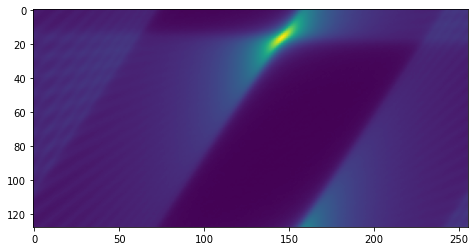

In [243]:
print(y_test.iloc[2])
plt.figure(figsize=(10,4))
plt.imshow(X_test[2].T)
plt.show()

Amplitudes              4.289653
Frequencies            52.803998
Daping coeffitients     1.046678
Speeds                 -7.282543
Name: 0, dtype: float64


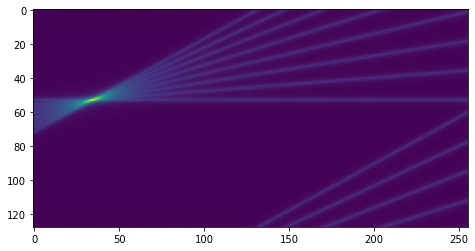

In [246]:
print(y_test.iloc[67])
plt.figure(figsize=(10,4))
plt.imshow(X_test[67].T)
plt.show()

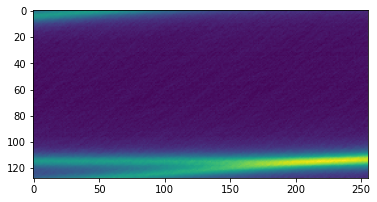

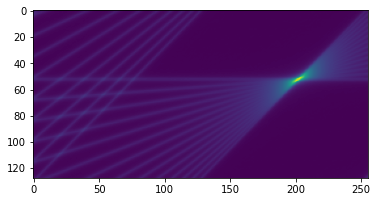

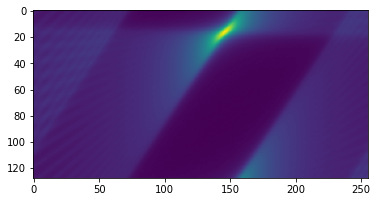

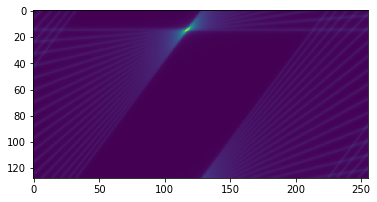

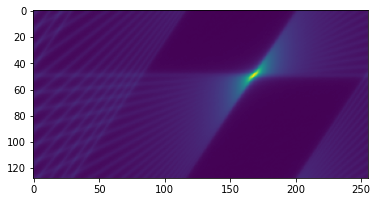

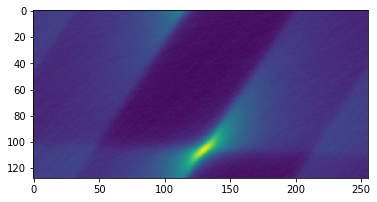

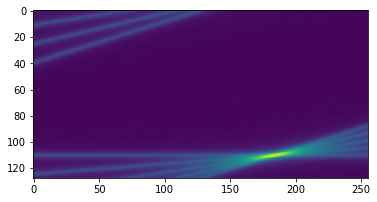

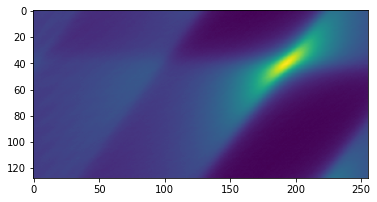

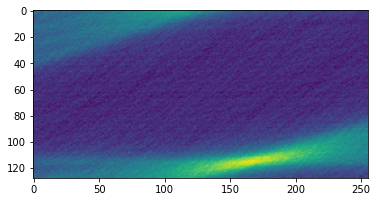

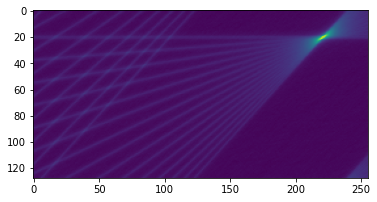

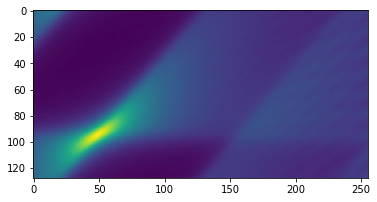

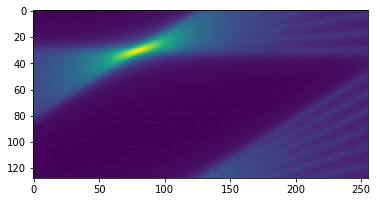

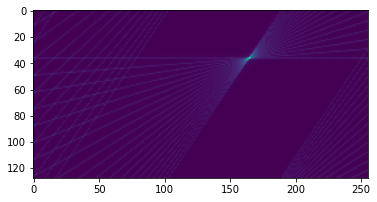

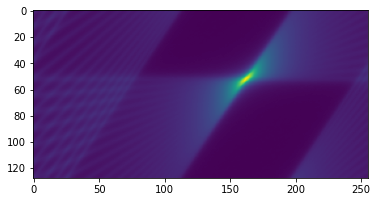

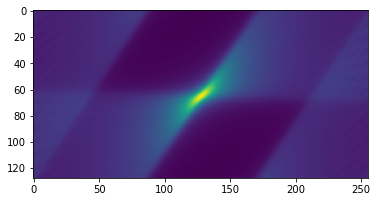

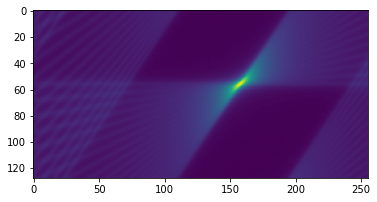

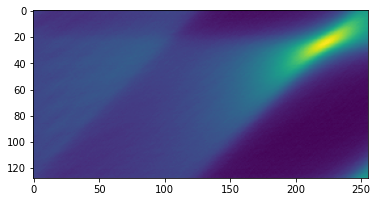

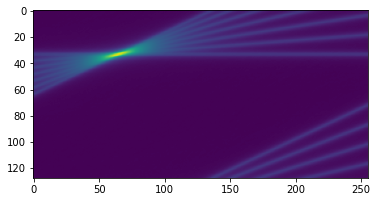

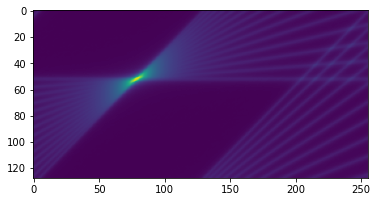

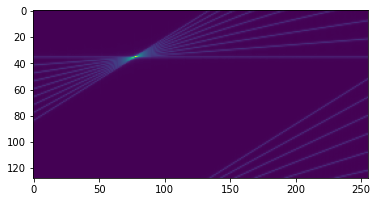

In [286]:
for element in X_test[:20]:
    plt.imshow(element.T)
    plt.show()

In [22]:
@tf.function
def normalize(spectrum, target):
    amplitude, frequency, damping, speed = target
    spectrum = (spectrum - 18.439472) / 25.953499
    amplitude = (amplitude - 2.5182393) / 1.3739507
    frequency = (frequency - 64.331924) / 31.369093
    damping = (damping - 5.200225) / 2.8327253
    speed = (speed + 0.07005237) / 4.654785
    return spectrum, (amplitude, frequency, damping, speed)

In [23]:
dataset = tf.data.Dataset.from_generator(generate,
                                         output_signature = (tf.TensorSpec([256, 128, 1]),
                                                             (tf.TensorSpec([]), tf.TensorSpec([]),
                                                              tf.TensorSpec([]), tf.TensorSpec([]))))

In [24]:
dataset = dataset.map(normalize).batch(256)

In [9]:
spectrum = tf.keras.Input([256, 128, 1])
signal = tf.keras.layers.Conv2D(32, 3, 1, 'same', activation = 'relu')(spectrum)
signal = tf.keras.layers.Conv2D(32, 3, 1, 'same', activation = 'relu')(signal)
signal = tf.keras.layers.MaxPool2D()(signal)
signal = tf.keras.layers.Conv2D(64, 3, 1, 'same', activation = 'relu')(signal)
signal = tf.keras.layers.Conv2D(64, 3, 1, 'same', activation = 'relu')(signal)
signal = tf.keras.layers.MaxPool2D()(signal)
signal = tf.keras.layers.Conv2D(128, 3, 1, 'same', activation = 'relu')(signal)
signal = tf.keras.layers.Conv2D(128, 3, 1, 'same', activation = 'relu')(signal)
signal = tf.keras.layers.MaxPool2D()(signal)
signal = tf.keras.layers.Flatten()(signal)
signal = tf.keras.layers.Dense(256, activation = 'relu')(signal)
amplitude = tf.keras.layers.Dense(1, name = 'amplitude')(signal)
frequency = tf.keras.layers.Dense(1, name = 'frequency')(signal)
damping = tf.keras.layers.Dense(1, name = 'damping')(signal)
speed = tf.keras.layers.Dense(1, name = 'speed')(signal)
model = tf.keras.models.Model(spectrum, (amplitude, frequency, damping, speed))
tf.keras.utils.plot_model(model, to_file='model_1.png', show_shapes=True)
model.summary()

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 256, 128, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 256, 128, 32) 9248        conv2d_6[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 128,

In [14]:
model.compile(optimizer = 'adam',loss=
              {'amplitude': 'mean_squared_error',
               'frequency': 'mean_squared_error',
               'damping': 'mean_squared_error',
               'speed': 'mean_squared_error'})

In [29]:
model.fit(dataset, steps_per_epoch = 2, epochs = 10000,
          callbacks = [tf.keras.callbacks.CSVLogger('raman15.csv', ' '),
                       tf.keras.callbacks.ModelCheckpoint('raman15.h5',
                                                          monitor = 'loss',
                                                          verbose = 1,
                                                          save_best_only = True,
                                                          save_weights_only = True)])

Epoch 1/10000
2/2 [==============================] - 52s 25s/step - loss: 4.1491 - amplitude_loss: 1.1456 - frequency_loss: 0.9542 - damping_loss: 0.9712 - speed_loss: 1.0780

Epoch 00001: loss improved from inf to 4.14907, saving model to raman15.h5
Epoch 2/10000
2/2 [==============================] - 50s 25s/step - loss: 3.9804 - amplitude_loss: 1.0317 - frequency_loss: 0.9871 - damping_loss: 0.9742 - speed_loss: 0.9874

Epoch 00002: loss improved from 4.14907 to 3.98039, saving model to raman15.h5
Epoch 3/10000
2/2 [==============================] - 52s 27s/step - loss: 3.8857 - amplitude_loss: 1.0355 - frequency_loss: 0.9342 - damping_loss: 0.9526 - speed_loss: 0.9634

Epoch 00003: loss improved from 3.98039 to 3.88574, saving model to raman15.h5
Epoch 4/10000
2/2 [==============================] - 52s 27s/step - loss: 3.9024 - amplitude_loss: 0.9708 - frequency_loss: 0.9594 - damping_loss: 1.0055 - speed_loss: 0.9668

Epoch 00004: loss did not improve from 3.88574
Epoch 5/10000
2/


Epoch 00068: loss did not improve from 0.21732
Epoch 69/10000
2/2 [==============================] - 55s 28s/step - loss: 0.1905 - amplitude_loss: 0.0352 - frequency_loss: 0.0353 - damping_loss: 0.0835 - speed_loss: 0.0366

Epoch 00069: loss improved from 0.21732 to 0.19051, saving model to raman15.h5
Epoch 70/10000
2/2 [==============================] - 54s 28s/step - loss: 0.2279 - amplitude_loss: 0.0427 - frequency_loss: 0.0366 - damping_loss: 0.1038 - speed_loss: 0.0448

Epoch 00070: loss did not improve from 0.19051
Epoch 71/10000
2/2 [==============================] - 56s 28s/step - loss: 0.1860 - amplitude_loss: 0.0426 - frequency_loss: 0.0319 - damping_loss: 0.0774 - speed_loss: 0.0342

Epoch 00071: loss improved from 0.19051 to 0.18604, saving model to raman15.h5
Epoch 72/10000
2/2 [==============================] - 55s 28s/step - loss: 0.2394 - amplitude_loss: 0.0496 - frequency_loss: 0.0393 - damping_loss: 0.0938 - speed_loss: 0.0567

Epoch 00072: loss did not improve from 

2/2 [==============================] - 55s 28s/step - loss: 0.1230 - amplitude_loss: 0.0235 - frequency_loss: 0.0120 - damping_loss: 0.0700 - speed_loss: 0.0176

Epoch 00140: loss did not improve from 0.08594
Epoch 141/10000
2/2 [==============================] - 55s 28s/step - loss: 0.1142 - amplitude_loss: 0.0224 - frequency_loss: 0.0142 - damping_loss: 0.0590 - speed_loss: 0.0186

Epoch 00141: loss did not improve from 0.08594
Epoch 142/10000
2/2 [==============================] - 56s 28s/step - loss: 0.1543 - amplitude_loss: 0.0296 - frequency_loss: 0.0217 - damping_loss: 0.0766 - speed_loss: 0.0263

Epoch 00142: loss did not improve from 0.08594
Epoch 143/10000
2/2 [==============================] - 55s 28s/step - loss: 0.0982 - amplitude_loss: 0.0209 - frequency_loss: 0.0155 - damping_loss: 0.0448 - speed_loss: 0.0170

Epoch 00143: loss did not improve from 0.08594
Epoch 144/10000
2/2 [==============================] - 56s 28s/step - loss: 0.0901 - amplitude_loss: 0.0187 - freque

2/2 [==============================] - 55s 28s/step - loss: 0.0626 - amplitude_loss: 0.0134 - frequency_loss: 0.0088 - damping_loss: 0.0300 - speed_loss: 0.0103

Epoch 00211: loss did not improve from 0.04375
Epoch 212/10000
2/2 [==============================] - 55s 28s/step - loss: 0.0501 - amplitude_loss: 0.0106 - frequency_loss: 0.0099 - damping_loss: 0.0180 - speed_loss: 0.0116

Epoch 00212: loss did not improve from 0.04375
Epoch 213/10000
2/2 [==============================] - 56s 28s/step - loss: 0.0384 - amplitude_loss: 0.0087 - frequency_loss: 0.0049 - damping_loss: 0.0165 - speed_loss: 0.0083

Epoch 00213: loss improved from 0.04375 to 0.03841, saving model to raman15.h5
Epoch 214/10000
2/2 [==============================] - 55s 28s/step - loss: 0.0476 - amplitude_loss: 0.0094 - frequency_loss: 0.0066 - damping_loss: 0.0254 - speed_loss: 0.0063

Epoch 00214: loss did not improve from 0.03841
Epoch 215/10000
2/2 [==============================] - 56s 28s/step - loss: 0.0591 -

2/2 [==============================] - 56s 28s/step - loss: 0.0460 - amplitude_loss: 0.0119 - frequency_loss: 0.0063 - damping_loss: 0.0187 - speed_loss: 0.0091

Epoch 00247: loss did not improve from 0.03362
Epoch 248/10000
2/2 [==============================] - 56s 28s/step - loss: 0.0487 - amplitude_loss: 0.0094 - frequency_loss: 0.0087 - damping_loss: 0.0220 - speed_loss: 0.0087

Epoch 00248: loss did not improve from 0.03362
Epoch 249/10000
2/2 [==============================] - 56s 28s/step - loss: 0.0521 - amplitude_loss: 0.0109 - frequency_loss: 0.0080 - damping_loss: 0.0216 - speed_loss: 0.0116

Epoch 00249: loss did not improve from 0.03362
Epoch 250/10000
2/2 [==============================] - 55s 28s/step - loss: 0.0590 - amplitude_loss: 0.0102 - frequency_loss: 0.0060 - damping_loss: 0.0342 - speed_loss: 0.0087

Epoch 00250: loss did not improve from 0.03362
Epoch 251/10000
2/2 [==============================] - 56s 28s/step - loss: 0.0396 - amplitude_loss: 0.0075 - freque


Epoch 00282: loss did not improve from 0.02023
Epoch 283/10000
2/2 [==============================] - 56s 28s/step - loss: 0.0817 - amplitude_loss: 0.0258 - frequency_loss: 0.0102 - damping_loss: 0.0302 - speed_loss: 0.0154

Epoch 00283: loss did not improve from 0.02023
Epoch 284/10000
2/2 [==============================] - 56s 28s/step - loss: 0.0568 - amplitude_loss: 0.0199 - frequency_loss: 0.0075 - damping_loss: 0.0210 - speed_loss: 0.0084

Epoch 00284: loss did not improve from 0.02023
Epoch 285/10000
2/2 [==============================] - 56s 28s/step - loss: 0.0721 - amplitude_loss: 0.0172 - frequency_loss: 0.0100 - damping_loss: 0.0298 - speed_loss: 0.0151

Epoch 00285: loss did not improve from 0.02023
Epoch 286/10000
2/2 [==============================] - 57s 29s/step - loss: 0.0872 - amplitude_loss: 0.0194 - frequency_loss: 0.0100 - damping_loss: 0.0432 - speed_loss: 0.0145

Epoch 00286: loss did not improve from 0.02023
Epoch 287/10000
2/2 [==============================]

2/2 [==============================] - 56s 28s/step - loss: 0.0258 - amplitude_loss: 0.0060 - frequency_loss: 0.0038 - damping_loss: 0.0099 - speed_loss: 0.0062

Epoch 00355: loss did not improve from 0.01565
Epoch 356/10000
2/2 [==============================] - 54s 28s/step - loss: 0.0191 - amplitude_loss: 0.0062 - frequency_loss: 0.0034 - damping_loss: 0.0047 - speed_loss: 0.0048

Epoch 00356: loss did not improve from 0.01565
Epoch 357/10000
2/2 [==============================] - 55s 28s/step - loss: 0.0252 - amplitude_loss: 0.0057 - frequency_loss: 0.0046 - damping_loss: 0.0089 - speed_loss: 0.0060

Epoch 00357: loss did not improve from 0.01565
Epoch 358/10000
2/2 [==============================] - 56s 28s/step - loss: 0.0224 - amplitude_loss: 0.0064 - frequency_loss: 0.0029 - damping_loss: 0.0095 - speed_loss: 0.0036

Epoch 00358: loss did not improve from 0.01565
Epoch 359/10000
2/2 [==============================] - 56s 28s/step - loss: 0.0253 - amplitude_loss: 0.0069 - freque

2/2 [==============================] - 56s 28s/step - loss: 0.0251 - amplitude_loss: 0.0066 - frequency_loss: 0.0032 - damping_loss: 0.0080 - speed_loss: 0.0073

Epoch 00427: loss did not improve from 0.01490
Epoch 428/10000
2/2 [==============================] - 56s 28s/step - loss: 0.0182 - amplitude_loss: 0.0058 - frequency_loss: 0.0026 - damping_loss: 0.0062 - speed_loss: 0.0036

Epoch 00428: loss did not improve from 0.01490
Epoch 429/10000
2/2 [==============================] - 56s 28s/step - loss: 0.0195 - amplitude_loss: 0.0042 - frequency_loss: 0.0025 - damping_loss: 0.0093 - speed_loss: 0.0035

Epoch 00429: loss did not improve from 0.01490
Epoch 430/10000
2/2 [==============================] - 55s 27s/step - loss: 0.0173 - amplitude_loss: 0.0048 - frequency_loss: 0.0020 - damping_loss: 0.0074 - speed_loss: 0.0031

Epoch 00430: loss did not improve from 0.01490
Epoch 431/10000
2/2 [==============================] - 55s 28s/step - loss: 0.0184 - amplitude_loss: 0.0061 - freque

2/2 [==============================] - 55s 28s/step - loss: 0.0128 - amplitude_loss: 0.0040 - frequency_loss: 0.0026 - damping_loss: 0.0032 - speed_loss: 0.0030

Epoch 00499: loss did not improve from 0.01226
Epoch 500/10000
2/2 [==============================] - 56s 28s/step - loss: 0.0128 - amplitude_loss: 0.0044 - frequency_loss: 0.0018 - damping_loss: 0.0047 - speed_loss: 0.0019

Epoch 00500: loss did not improve from 0.01226
Epoch 501/10000
2/2 [==============================] - 55s 28s/step - loss: 0.0114 - amplitude_loss: 0.0035 - frequency_loss: 0.0021 - damping_loss: 0.0036 - speed_loss: 0.0022

Epoch 00501: loss improved from 0.01226 to 0.01140, saving model to raman15.h5
Epoch 502/10000
2/2 [==============================] - 55s 28s/step - loss: 0.0122 - amplitude_loss: 0.0045 - frequency_loss: 0.0023 - damping_loss: 0.0032 - speed_loss: 0.0023

Epoch 00502: loss did not improve from 0.01140
Epoch 503/10000
2/2 [==============================] - 56s 28s/step - loss: 0.0126 -

Epoch 535/10000
2/2 [==============================] - 55s 28s/step - loss: 0.0123 - amplitude_loss: 0.0026 - frequency_loss: 0.0018 - damping_loss: 0.0053 - speed_loss: 0.0025

Epoch 00535: loss did not improve from 0.00787
Epoch 536/10000
2/2 [==============================] - 56s 28s/step - loss: 0.0107 - amplitude_loss: 0.0030 - frequency_loss: 0.0018 - damping_loss: 0.0035 - speed_loss: 0.0024

Epoch 00536: loss did not improve from 0.00787
Epoch 537/10000
2/2 [==============================] - 56s 28s/step - loss: 0.0122 - amplitude_loss: 0.0027 - frequency_loss: 0.0020 - damping_loss: 0.0045 - speed_loss: 0.0029

Epoch 00537: loss did not improve from 0.00787
Epoch 538/10000
2/2 [==============================] - 56s 28s/step - loss: 0.0081 - amplitude_loss: 0.0021 - frequency_loss: 0.0014 - damping_loss: 0.0025 - speed_loss: 0.0020

Epoch 00538: loss did not improve from 0.00787
Epoch 539/10000
2/2 [==============================] - 56s 28s/step - loss: 0.0112 - amplitude_loss:

2/2 [==============================] - 55s 28s/step - loss: 0.0082 - amplitude_loss: 0.0025 - frequency_loss: 0.0014 - damping_loss: 0.0024 - speed_loss: 0.0018

Epoch 00607: loss did not improve from 0.00683
Epoch 608/10000
2/2 [==============================] - 55s 28s/step - loss: 0.0095 - amplitude_loss: 0.0028 - frequency_loss: 0.0015 - damping_loss: 0.0038 - speed_loss: 0.0015

Epoch 00608: loss did not improve from 0.00683
Epoch 609/10000
2/2 [==============================] - 55s 28s/step - loss: 0.0088 - amplitude_loss: 0.0027 - frequency_loss: 0.0011 - damping_loss: 0.0030 - speed_loss: 0.0020

Epoch 00609: loss did not improve from 0.00683
Epoch 610/10000
2/2 [==============================] - 55s 28s/step - loss: 0.0081 - amplitude_loss: 0.0022 - frequency_loss: 0.0012 - damping_loss: 0.0027 - speed_loss: 0.0020

Epoch 00610: loss did not improve from 0.00683
Epoch 611/10000
2/2 [==============================] - 56s 28s/step - loss: 0.0078 - amplitude_loss: 0.0024 - freque

2/2 [==============================] - 55s 28s/step - loss: 0.0170 - amplitude_loss: 0.0043 - frequency_loss: 0.0017 - damping_loss: 0.0080 - speed_loss: 0.0030

Epoch 00679: loss did not improve from 0.00561
Epoch 680/10000
2/2 [==============================] - 55s 28s/step - loss: 0.0117 - amplitude_loss: 0.0032 - frequency_loss: 0.0014 - damping_loss: 0.0053 - speed_loss: 0.0019

Epoch 00680: loss did not improve from 0.00561
Epoch 681/10000
2/2 [==============================] - 55s 28s/step - loss: 0.0134 - amplitude_loss: 0.0028 - frequency_loss: 0.0024 - damping_loss: 0.0052 - speed_loss: 0.0030

Epoch 00681: loss did not improve from 0.00561
Epoch 682/10000
2/2 [==============================] - 55s 28s/step - loss: 0.0146 - amplitude_loss: 0.0032 - frequency_loss: 0.0020 - damping_loss: 0.0073 - speed_loss: 0.0022

Epoch 00682: loss did not improve from 0.00561
Epoch 683/10000
2/2 [==============================] - 55s 27s/step - loss: 0.0125 - amplitude_loss: 0.0032 - freque

KeyboardInterrupt: 

In [189]:
raman15 = pd.read_csv('raman15.csv', sep=' ')
raman15.head()

,epoch,amplitude_loss,damping_loss,frequency_loss,loss,speed_loss
0,0,1.145627,0.971175,0.954234,4.149065,1.078028
1,1,1.031732,0.974205,0.987092,3.980390,0.987360
2,2,1.035546,0.952555,0.934250,3.885741,0.963391
3,3,0.970844,1.005452,0.959374,3.902443,0.966772
4,4,0.910921,0.897676,0.901712,3.704720,0.994411


In [30]:
model.load_weights('raman15.h5')

In [125]:
result = model.evaluate(dataset, steps = 16)

16/16 [==============================] - 134s 8s/step - loss: 0.0069 - amplitude_loss: 0.0019 - frequency_loss: 0.0015 - damping_loss: 0.0021 - speed_loss: 0.0016


In [126]:
result

[0.006935863755643368,
 0.001851995475590229,
 0.0014638514257967472,
 0.002051293384283781,
 0.001568724517710507]

In [206]:
y_pred = model.predict(X_test)

In [200]:
X_test.shape

(500, 256, 128)

In [207]:
y_pred

(array([[-1.0489721 ],
        [ 0.3850718 ],
        [ 1.0695994 ],
        [-1.5486734 ],
        [ 0.0663699 ],
        [-1.6389636 ],
        [ 0.5339673 ],
        [-0.74001664],
        [ 0.56021875],
        [-1.070224  ],
        [-0.09559117],
        [-1.047498  ],
        [ 1.0595713 ],
        [-0.88424975],
        [ 1.2239441 ],
        [ 1.3215448 ],
        [ 0.11080369],
        [ 0.13128687],
        [-0.3683902 ],
        [-0.39472246],
        [ 1.3396022 ],
        [ 0.2850166 ],
        [ 1.7448993 ],
        [-0.11704087],
        [ 1.4746978 ],
        [-0.7720948 ],
        [-1.5555674 ],
        [ 1.4545155 ],
        [-1.0557911 ],
        [ 0.53142273],
        [-0.79660773],
        [-1.7451298 ],
        [ 0.6093801 ],
        [-1.6669469 ],
        [ 0.5032382 ],
        [ 0.43655574],
        [-1.0921682 ],
        [ 1.3301332 ],
        [ 0.9805125 ],
        [ 0.2502188 ],
        [ 0.0387778 ],
        [-0.25192693],
        [-1.5548396 ],
        [ 0

In [256]:
amp, freq, damp, speed = y_pred

In [257]:
amp.shape

(500, 1)

In [258]:
y_test=y_test[:100]

In [259]:
amp = (amp * 1.3739507) + 2.5182393 
freq = (freq * 31.369093) + 64.331924
damp = (damp * 2.8327253) + 5.200225
speed = (speed * 4.654785) + 0.07005237

In [260]:
amp=amp[:100]
freq=freq[:100]
damp=damp[:100]
speed=speed[:100]

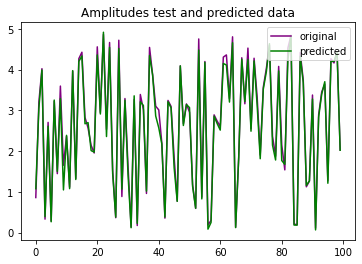

In [276]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test.iloc[:,0], label="original", color='purple')
plt.plot(x_ax, amp, label="predicted", color='green')
plt.title("Amplitudes test and predicted data")
plt.legend(loc='upper right')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

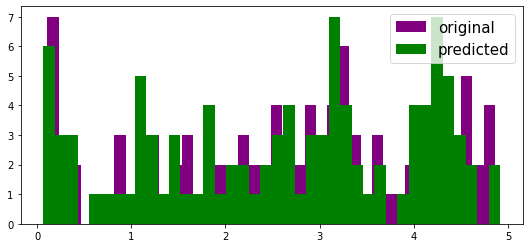

In [275]:
plt.figure(figsize=(9,4))
plt.hist(y_test.iloc[:,0], bins=40, label='original', color='purple')
plt.hist(amp, bins=40, label='predicted', color='green')
plt.legend(loc='upper right', fontsize=15)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

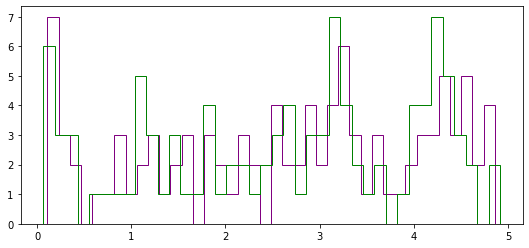

In [277]:
plt.figure(figsize=(9,4))
plt.hist(y_test.iloc[:,0], bins=40, histtype='step', label='original', color='purple')
plt.hist(amp, bins=40, histtype='step', label='predicted', color='green')
plt.show

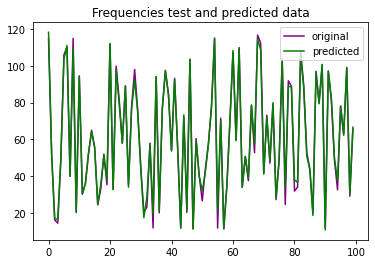

In [278]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test.iloc[:,1], label="original", color='purple')
plt.plot(x_ax, freq, label="predicted", color='green')
plt.title("Frequencies test and predicted data")
plt.legend(loc='upper right')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

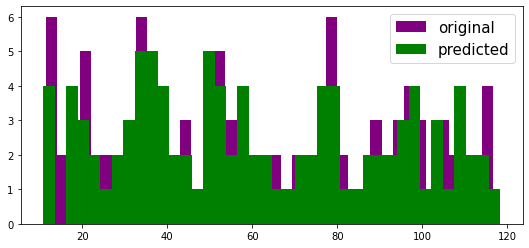

In [281]:
plt.figure(figsize=(9,4))
plt.hist(y_test.iloc[:,1], bins=40, label='original', color='purple')
plt.hist(freq, bins=40, label='predicted', color='green')
plt.legend(loc='upper right', fontsize=15)
plt.show

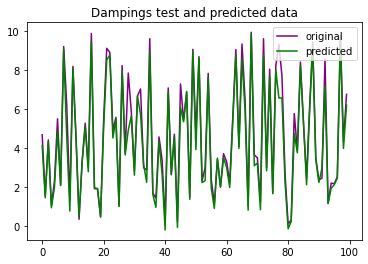

In [279]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test.iloc[:,2], label="original", color='purple')
plt.plot(x_ax, damp, label="predicted", color='green')
plt.title("Dampings test and predicted data")
plt.legend(loc='upper right')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

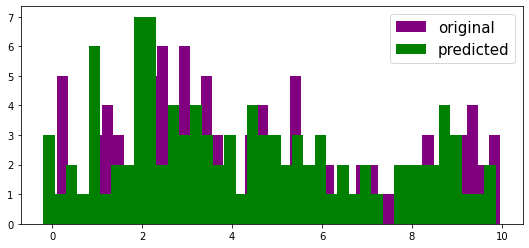

In [282]:
plt.figure(figsize=(9,4))
plt.hist(y_test.iloc[:,2], bins=40, label='original', color='purple')
plt.hist(damp, bins=40, label='predicted', color='green')
plt.legend(loc='upper right', fontsize=15)
plt.show

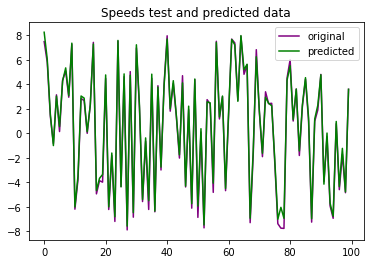

In [280]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test.iloc[:,3], label="original", color='purple')
plt.plot(x_ax, speed, label="predicted", color='green')
plt.title("Speeds test and predicted data")
plt.legend(loc='upper right')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

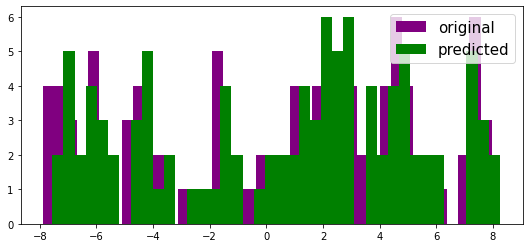

In [283]:
plt.figure(figsize=(9,4))
plt.hist(y_test.iloc[:,3], bins=40, label='original', color='purple')
plt.hist(speed, bins=40, label='predicted', color='green')
plt.legend(loc='upper right', fontsize=15)
plt.show

In [234]:
bins = 64

In [235]:
amplitudes = np.zeros(bins)
frequencies = np.zeros(bins)
dampings = np.zeros(bins)
speeds = np.zeros(bins)

In [236]:
for spectrum, (amplitude0, frequency0, damping0, speed0) in dataset.take(256):
    print('#', end = ' ', flush = True)
    amplitude1, frequency1, damping1, speed1 = model(spectrum)
    amplitude0 = amplitude0.numpy()
    frequency0 = frequency0.numpy()
    damping0 = damping0.numpy()
    speed0 = speed0.numpy()
    amplitude1 = amplitude1.numpy().squeeze()
    frequency1 = frequency1.numpy().squeeze()
    damping1 = damping1.numpy().squeeze()
    speed1 = speed1.numpy().squeeze()
    amplitude, _ = np.histogram(amplitude1 - amplitude0, bins = bins, range = (-0.1, 0.1))
    frequency, _ = np.histogram(frequency1 - frequency0, bins = bins, range = (-0.1, 0.1))
    damping, _ = np.histogram(damping1 - damping0, bins = bins, range = (-0.1, 0.1))
    speed, _ = np.histogram(speed1 - speed0, bins = bins, range = (-0.1, 0.1))
    amplitudes += amplitude
    frequencies += frequency
    dampings += damping
    speeds += speed

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

In [237]:
amplitudes *= bins / amplitudes.sum() / 0.2
frequencies *= bins / frequencies.sum() / 0.2
dampings *= bins / dampings.sum() / 0.2
speeds *= bins / speeds.sum() / 0.2

In [238]:
def gauss(x, mean, std):
    return np.exp(-((x - mean) / std) ** 2 / 2) / std / np.sqrt(2 * np.pi)

In [239]:
x = np.linspace(-0.1, 0.1, 256)

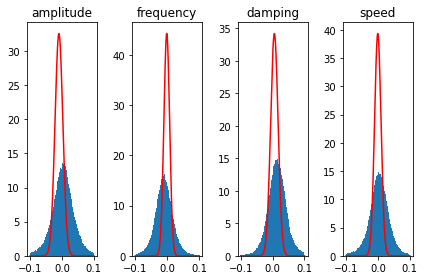

In [240]:
plt.figure(tight_layout = True)
plt.subplot(1, 4, 1, title = 'amplitude')
plt.bar(-0.1 + 0.2 * np.arange(bins) / bins, amplitudes, width = 0.2 / bins, align = 'edge')
plt.plot(x, gauss(x, -0.009575228206813335, 0.012250964529812336), color = 'red')
plt.subplot(1, 4, 2, title = 'frequency')
plt.bar(-0.1 + 0.2 * np.arange(bins) / bins, frequencies, width = 0.2 / bins, align = 'edge')
plt.plot(x, gauss(x, -0.0016916199820116162, 0.009006371721625328), color = 'red')
plt.subplot(1, 4, 3, title = 'damping')
plt.bar(-0.1 + 0.2 * np.arange(bins) / bins, dampings, width = 0.2 / bins, align = 'edge')
plt.plot(x, gauss(x, 0.005617320537567139, 0.011655943468213081), color = 'red')
plt.subplot(1, 4, 4, title = 'speed')
plt.bar(-0.1 + 0.2 * np.arange(bins) / bins, speeds, width = 0.2 / bins, align = 'edge')
plt.plot(x, gauss(x, -0.0003206302353646606, 0.010134946554899216), color = 'red')

plt.show()